In [1]:
%matplotlib notebook

# %qtconsole

import logging
import time
from importlib import reload

from matplotlib import pyplot as plt
from matplotlib import colors, cm
import numpy as np

import qcodes

In [ ]:
%qtconsole

# Imports

In [2]:
from pytopo.rf.alazar import acquisition_tools; reload(acquisition_tools)
from pytopo.rf.alazar import awg_sequences; reload(awg_sequences)
from pytopo.rf.alazar import acquisition_controllers; reload(acquisition_controllers)

<module 'pytopo.rf.alazar.acquisition_controllers' from 'd:\\onedrive\\bf2\\code\\pytopo\\pytopo\\rf\\alazar\\acquisition_controllers.py'>

# Init

## initialize station, create instruments

In [4]:
%run -i D:/OneDrive/BF2/Code/BF2/BF2/init_station_cqed.py

Connected to: TEKTRONIX AWG5208 (serial:B020237, firmware:FV:6.1.0054.0) in 0.26s


In [5]:
raw_acq = instools.create_inst(acquisition_controllers.RawAcqCtl, 
                               'raw_acq', 'alazar',
                               allocate_samples=1e9, 
                               force_new_instance=True)

post_demod_acq = instools.create_inst(acquisition_controllers.PostDemodCtl, 
                                      'post_demod_acq', 'alazar',
                                      allocate_samples=1e9, 
                                      force_new_instance=True)

post_iq_acq = instools.create_inst(acquisition_controllers.PostIQCtl, 
                                   'post_iq_acq', 'alazar',
                                   allocate_samples=1e9, 
                                   force_new_instance=True)

Allocating 1000000000 elements (2000.0 MB)
Allocating 1000000000 elements (4000.0 MB)
Allocating 1000000000 elements (4000.0 MB)


## Basic instrument config

## Test sequence

<IPython.core.display.Javascript object>


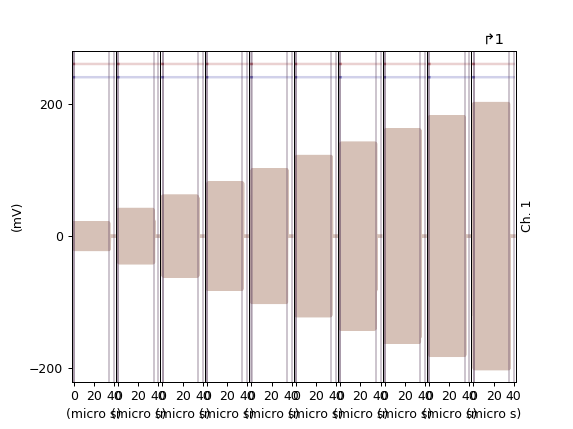

Waveforms done
['wfm_1_1_1', 'wfm_2_1_1', 'wfm_3_1_1', 'wfm_4_1_1', 'wfm_5_1_1', 'wfm_6_1_1', 'wfm_7_1_1', 'wfm_8_1_1', 'wfm_9_1_1', 'wfm_10_1_1']
True debug
[['wfm_1_1_1', 'wfm_10_1_1'], ['wfm_2_1_1'], ['wfm_3_1_1'], ['wfm_4_1_1'], ['wfm_5_1_1'], ['wfm_6_1_1'], ['wfm_7_1_1'], ['wfm_8_1_1'], ['wfm_9_1_1'], ['wfm_10_1_1']]


In [26]:
N = 10
pulse_times = [35e-6] * N
amplitudes = np.arange(N) * 0.02 + 0.02
frequencies = [1e6] * N
phases = np.arange(N) * 2 * np.pi/N
cycle_time = 40e-6

awg_sequences.make_test_sequence(station.awg, pulse_times, frequencies, phases, amplitudes, 
                                 cycle_time=cycle_time, pre_trig_time=0.1e-6, trig_time=0.1e-6)

In [16]:
np.arange(N) * 0.02 + 0.02

array([ 0.02,  0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,  0.18,  0.2 ])

# Test basic controllers

## Raw data

In [27]:
ctl = raw_acq

t_rep = 40e-6
nsamples = 3840
npts = int(1e4)
nrecords = 100
alloc_buffers = 10
SR = 1e8

t_total = npts * t_rep
nbuffers = npts // nrecords

t, data = acquisition_tools.time_acquisition(ctl, nsamples, nrecords, nbuffers, 
                                             alloc_buffers=alloc_buffers, SR=SR, t_total=t_total)

Setup capture: 153.6 MB total
 * Buffers: 100 (1.5359999999999998 MB/buffer) | (Allocated buffers: 10 = 15.359999999999998 MB)
 * Records: 100 (0.015359999999999999 MB/record)
 * Samples: 3840 (= 38.4 us)
 * Channels: 2
done: 0.3528593254684438 s
Acquistion: 2.658966 sec.
Net time: 0.400000 sec.
Overhead: 6.65 X
Mean buffer handling time: 0.6 ms
post_acquire time: 2.20 s
Data shape: (1, 100, 100, 3840, 2)

 buffers cleared
buffers cleared
Captured 100 buffers (233.267664 buffers per sec)
Captured 10000 records (23326.766402 records per sec)
Transferred 1.536e+08 bytes (3.58299e+08 bytes per sec)
Pre setup took 0.029469580780869364
Pre capture setup took 7.624476916134881e-05
Capture took 0.4014023172545649
abort took 0.02263492147267243
handling took 9.774970521903015e-07
free mem took 0.004508705099965482
tot acquire time is 0.45816166041561246



<IPython.core.display.Javascript object>


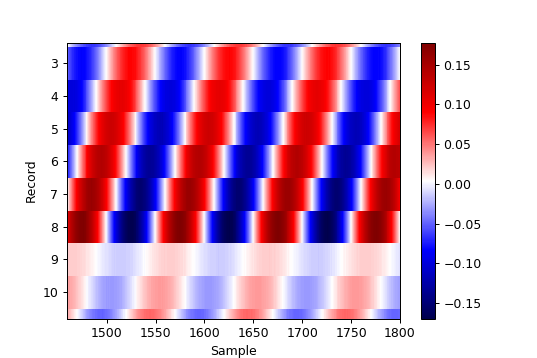

<IPython.core.display.Javascript object>


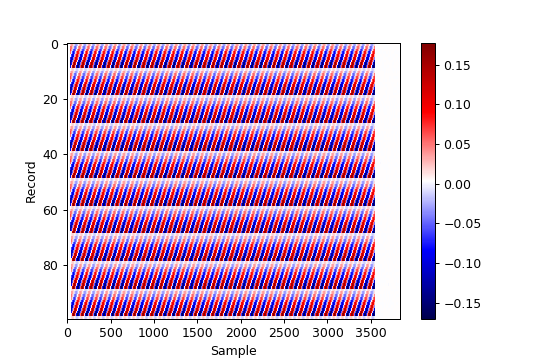

Text(0,0.5,'Record')

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
im = ax.imshow(data[0, 0, :, :, 0], cmap=cm.seismic, aspect='auto')
cb = fig.colorbar(im)

ax.set_xlabel('Sample')
ax.set_ylabel('Record')

fig, ax = plt.subplots(1, 1, figsize=(6,4))
im = ax.imshow(data[0, -1, :, :, 0], cmap=cm.seismic, aspect='auto')
cb = fig.colorbar(im)

ax.set_xlabel('Sample')
ax.set_ylabel('Record')

In [ ]:
avgdata = data.mean(axis=0)

fig, ax = plt.subplots(1, 1)
ax.plot(avgdata[4, :, 0], 'o-')

## Post-acq. demodulation

### Only demodulation

In [29]:
ctl = post_demod_acq
ctl.average_buffers(True)

demod_frq = 1e6
t_rep = 40e-6
nsamples = 384
npts = int(1e5)
nrecords = 100
alloc_buffers = 10
SR = 1e7

t_total = npts * t_rep
nbuffers = npts // nrecords

t, data = acquisition_tools.time_acquisition(ctl, nsamples, nrecords, nbuffers, 
                                             alloc_buffers=alloc_buffers, 
                                             SR=SR, t_total=t_total)

print(f'post_acquire time: {ctl.post_acquire_time:.2f} s')
print('Data shape:', data.shape)

Setup capture: 307.20000000000005 MB total
 * Buffers: 1000 (0.30720000000000003 MB/buffer) | (Allocated buffers: 10 = 3.072 MB)
 * Records: 100 (0.003072 MB/record)
 * Samples: 384 (= 38.4 us)
 * Channels: 2
done: 0.31629116117846934 s
Acquistion: 4.224553 sec.
Net time: 4.000000 sec.
Overhead: 1.06 X
Mean buffer handling time: 0.0 ms
post_acquire time: 0.01 s
Data shape: (1, 1, 100, 38, 2)

 buffers cleared
buffers cleared
Captured 1000 buffers (239.009861 buffers per sec)
Captured 100000 records (23900.986065 records per sec)
Transferred 1.536e+08 bytes (3.67119e+07 bytes per sec)
Pre setup took 0.025733098343039273
Pre capture setup took 7.428977517065505e-05
Capture took 4.160598365038368
abort took 0.02236953102624284
handling took 9.774970521903015e-07
free mem took 0.0008171875259677108
tot acquire time is 4.209660896501646

post_acquire time: 0.01 s
Data shape: (1, 1, 100, 38, 2)


<IPython.core.display.Javascript object>


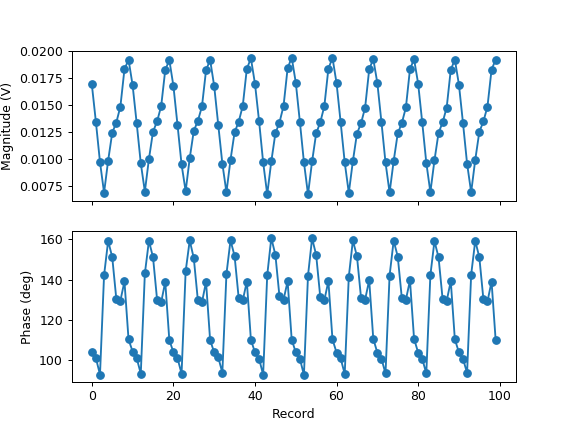

Text(0,0.5,'Phase (deg)')

In [30]:
iqdata = data.mean(axis=-2)
mag = np.abs(iqdata)
phase = np.angle(iqdata, deg=True)
phase[phase < -180] += 360

# fig, ax = plt.subplots(1,1)
# ax.plot(mag[0, :, 0], 'o-')
# ax.plot(mag[-1, :, 0] + 0.01, 'o-')

# fig, ax = plt.subplots(1,1)
# ax.plot(phase[0, :, 0], 'o-')
# ax.plot(phase[-1, :, 0]+50, 'o-')

fig, (ax, bx) = plt.subplots(2, 1, sharex='all')
ax.plot(mag[0, 0, :, 0], 'o-')
bx.plot(phase[0, 0, :, 0], 'o-')
bx.set_xlabel('Record')
ax.set_ylabel('Magnitude (V)')
bx.set_ylabel('Phase (deg)')

### Extracting I/Q

In [40]:
ctl = post_iq_acq
ctl.average_buffers(True)
ctl.buffers_per_block(None)
ctl.integration_start(1.25e-6)
ctl.integration_stop(11.25e-6)

demod_frq = 1e6
t_rep = 40e-6
nsamples = 3840
npts = int(1e5)
nrecords = 100
alloc_buffers = 10
SR = 1e8

t_total = npts * t_rep
nbuffers = npts // nrecords

t, data = acquisition_tools.time_acquisition(ctl, nsamples, nrecords, nbuffers, 
                                             alloc_buffers=alloc_buffers, 
                                             SR=SR, t_total=t_total)

print(f'post_acquire time: {ctl.post_acquire_time:.2f} s')
print('Data shape:', data.shape)

Setup capture: 3071.9999999999995 MB total
 * Buffers: 1000 (3.0719999999999996 MB/buffer) | (Allocated buffers: 10 = 30.719999999999995 MB)
 * Records: 100 (0.030719999999999997 MB/record)
 * Samples: 3840 (= 38.4 us)
 * Channels: 2
done: 0.3164817731014864 s
Acquistion: 4.190937 sec.
Net time: 4.000000 sec.
Overhead: 1.05 X
Mean buffer handling time: 0.0 ms
post_acquire time: 0.13 s
Data shape: (1, 1, 100, 2)

 buffers cleared
buffers cleared
Captured 1000 buffers (248.162260 buffers per sec)
Captured 100000 records (24816.226034 records per sec)
Transferred 1.536e+09 bytes (3.81177e+08 bytes per sec)
Pre setup took 0.030222742250657575
Pre capture setup took 7.868851173498115e-05
Capture took 4.003195926574335
abort took 0.022302083730437516
handling took 9.774970521903015e-07
free mem took 0.003984277937547631
tot acquire time is 4.059844323821267

post_acquire time: 0.13 s
Data shape: (1, 1, 100, 2)


<IPython.core.display.Javascript object>


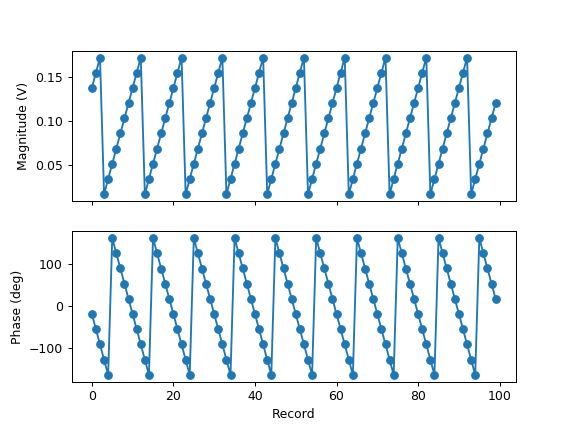

Text(0,0.5,'Phase (deg)')

In [41]:
mag = np.abs(data)
phase = np.angle(data, deg=True)
phase[phase < -180] += 360

# fig, ax = plt.subplots(1,1)
# ax.plot(mag[0, :, 0], 'o-')
# # ax.plot(mag[-1, :, 0] + 0.01, 'o-')

# fig, ax = plt.subplots(1,1)
# ax.plot(phase[0, :, 0], 'o-')
# # ax.plot(phase[-1, :, 0]+50, 'o-')

fig, (ax, bx) = plt.subplots(2, 1, sharex='all')
ax.plot(mag[0, 0, :, 0], 'o-')
bx.plot(phase[0, 0, :, 0], 'o-')
bx.set_xlabel('Record')
ax.set_ylabel('Magnitude (V)')
bx.set_ylabel('Phase (deg)')

### Extracting IQ and usage of buffer blocks

In [43]:
awg_sequences.make_trigger_sequence(station.awg, 1, 1, cycle_time=1e-3, 
                                    pre_trig_time=1e-6, trig_time=1e-6, ncycles=6,
                                    SR=1e7, debug_signal=True, wait=True, start_awg=True)

Waveforms done
['wfm_1_1_1', 'wfm_2_1_1', 'wfm_3_1_1', 'wfm_4_1_1', 'wfm_5_1_1', 'wfm_6_1_1']
True debug
[['wfm_1_1_1'], ['wfm_2_1_1'], ['wfm_3_1_1'], ['wfm_4_1_1'], ['wfm_5_1_1'], ['wfm_6_1_1']]


In [44]:
class MyPostIQCtl(acquisition_controllers.PostIQCtl):
    
    def _perform_step(self, num):        
        awg = station.awg
        while awg.run_state() != 'Waiting for trigger':
            time.sleep(0.01)
        
        time.sleep(0.01)
        if not (num+1) % self.buffers_per_block():
            inc = (num+1) // self.buffers_per_block()
            awg.ch1.awg_amplitude(0.25 + inc * 0.05)
            time.sleep(0.01)     
            
        awg.force_triggerA()
        
    def pre_acquire(self):
        super().pre_acquire()
        self._perform_step(0)
        self._perform_step(1)
    
    def buffer_done_callback(self, buffernum):
        nextstep = buffernum + 2
        self._perform_step(nextstep)

my_iq_acq = instools.create_inst(MyPostIQCtl, 
                                 'my_iq_acq', 'alazar',
                                 allocate_samples=1e9, 
                                 force_new_instance=True)

Allocating 1000000000 elements (4000.0 MB)


In [49]:
station.awg.ch1.awg_amplitude(0.25)

ctl = my_iq_acq
ctl.average_buffers(True)
ctl.buffers_per_block(10)

demod_frq = 1e6
t_rep = 1e-3
nsamples = 100e-6 * 1e8 // 128 * 128
nbuffers = 100
nrecords = 6
alloc_buffers = 10
SR = 1e8

t_total = nbuffers * t_rep

t, data = acquisition_tools.time_acquisition(ctl, nsamples, nrecords, nbuffers, 
                                             alloc_buffers=alloc_buffers, 
                                             SR=SR, t_total=t_total)

print(f'post_acquire time: {ctl.post_acquire_time:.2f} s')
print('Data shape:', data.shape)

Setup capture: 47.9232 MB total
 * Buffers: 100 (0.479232 MB/buffer) | (Allocated buffers: 10 = 4.79232 MB)
 * Records: 6 (0.079872 MB/record)
 * Samples: 9984 (= 99.84 us)
 * Channels: 2
done: 0.31895141937275184 s
Acquistion: 6.372938 sec.
Net time: 0.100000 sec.
Overhead: 63.73 X
Mean buffer handling time: 0.0 ms
post_acquire time: 0.19 s
Data shape: (10, 1, 6, 2)

 buffers cleared
buffers cleared
Captured 100 buffers (16.250060 buffers per sec)
Captured 600 records (97.500362 records per sec)
Transferred 2.39616e+07 bytes (3.89377e+06 bytes per sec)
Pre setup took 0.025292735925177112
Pre capture setup took 0.9017024088461767
Capture took 5.228157095501956
abort took 0.0228729420050513
handling took 1.4662437024526298e-06
free mem took 0.0010258831462124363
tot acquire time is 6.179116068975418

post_acquire time: 0.19 s
Data shape: (10, 1, 6, 2)


<IPython.core.display.Javascript object>


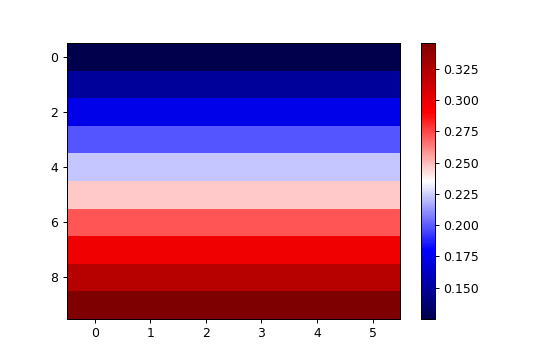

In [50]:
mag = np.abs(data)
phase = np.angle(data, deg=True)
phase[phase < -180] += 360

fig, ax = plt.subplots(1, 1, figsize=(6,4))
# ax.plot(mag[:, 0, 0, 0], 'o-')
im = ax.imshow(mag[:, 0, :, 0], cmap=cm.seismic, aspect='auto')
cb = fig.colorbar(im)

# ax.set_xlabel('Sample')
# ax.set_ylabel('Record')

# Simplified data acquisition

## Basic convenience functions

In [ ]:
data = simple_triggered_sweep_acquisition(100, 15e-6, navgs=10, SR=1e8,
                                          pre_acq_func=start_awg_func, 
                                          post_acq_func=stop_awg_func)

mag = np.abs(data)
phase = np.angle(data, deg=True)
phase[phase < -180] += 360

fig, (ax, bx) = plt.subplots(2, 1, sharex='all')
ax.plot(mag[0, :, 0], 'o-')
bx.plot(phase[0, :, 0], 'o-')
bx.set_xlabel('Record')
ax.set_ylabel('Magnitude (V)')
bx.set_ylabel('Phase (deg)')

## End-user functions

In [ ]:
def measure_test_sequence(ncycles, navgs, cycle_len=10, cycle_time=40e-6, SR=1e8):
    awg = awg = qc.Instrument.find_instrument(qc.config['user']['instruments']['awg_name'])
    
    pulse_times = np.ones(cycle_len) * cycle_time - 3e-6
    amplitudes = np.arange(cycle_len) * 0.02 + 0.02
    frequencies = [1e6] * cycle_len
    phases = np.arange(cycle_len) * 2 * np.pi/cycle_len    
    
    awg_test_sequence.make_test_sequence(awg, pulse_times, frequencies, phases, amplitudes, 
                                         cycle_time=cycle_time, pre_trig_time=1e-6, trig_time=1e-6,
                                         plot=False, start_awg=False)
    
    data = simple_triggered_sweep_acquisition(ncycles*10, cycle_time-1e-6, navgs=10, SR=SR,
                                              pre_acq_func=start_awg_func, 
                                              post_acq_func=stop_awg_func)

    mag = np.abs(data)
    phase = np.angle(data, deg=True)
    phase[phase < -180] += 360
    
    return mag, phase

In [ ]:
mag, phase = measure_test_sequence(10, 1)

fig, (ax, bx) = plt.subplots(2, 1, sharex='all')
ax.plot(mag[0, :, 0], 'o-')
bx.plot(phase[0, :, 0], 'o-')
bx.set_xlabel('Record')
ax.set_ylabel('Magnitude (V)')
bx.set_ylabel('Phase (deg)')

# Scribbles